In [1]:
from wordcloud import WordCloud

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import re

from langdetect import detect, LangDetectException
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

import lightgbm as lgb

RANDOM_STATE = 42
#pd.set_option('display.max_rows', None)

In [85]:
print(f'Pandas version: {pd.__version__}\n Numpy version: {np.__version__}\n NLTK version: {nltk.__version__}\n lightgbm version: {lgb.__version__}') 

Pandas version: 2.1.4
 Numpy version: 1.26.4
 NLTK version: 3.8.1
 lightgbm version: 4.3.0


In [2]:
# очистка текста 

def clear_text(text):
    text = str(text).lower()
    re_text = re.sub(r'[^a-zA-Zа-яА-Я0-9]', ' ', text.partition('http')[0])
    #res = " ".join(re_text.lower().split())
    res = re.sub(r'\s+', ' ', re_text).strip()
    
    return res

In [3]:
# лемматизация текса

def lemmatize(text):
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in stop_words] # для русского языка stemmer.stem(word)
    text = ' '.join([lemmatizer.lemmatize(w) for w in text])
    return text

In [4]:
# очистка текста от мусорных слов

def remove_words(df, column_name, words_to_remove):
    # Создаем регулярное выражение из списка слов
    pattern = r'\b(' + '|'.join(map(re.escape, words_to_remove)) + r')\b'
    
    # Функция для удаления слов из строки
    def clean_text(text):
        return re.sub(pattern, '', text, flags=re.IGNORECASE).strip()
    
    # Применяем функцию ко всем строкам в указанном столбце
    df[column_name] = df[column_name].apply(clean_text)
    return df

In [5]:
# Получение текстовой строки из списка слов

def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=stop_words,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

In [6]:
# замена значений в целевой переменной
def replace_values(df, index_list, correct_cartoon):
    df.loc[df.index.isin(index_list), 'cartoon'] = correct_cartoon
    return df

In [8]:
data = pd.read_csv('train_unioncartoon.csv', sep=',', encoding='utf-8', lineterminator='\n')
test = pd.read_csv('test_unioncartoon.csv', sep=',', encoding='utf-8', lineterminator='\n')

In [9]:
data.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN


In [10]:
keywords = data.query('cartoon != "none"')['cartoon'].unique()
for key in keywords:
    print(f'Проект {key}:\n', data[data['cartoon']==key]['yt_channel_id'].unique()) 

Проект Смешарики:
 ['UCiG0W88vIiJUPQdGIjqysMA' 'UC5A-Wp9ujcr5g9sYagAafEA'
 'UCnm_vYgguleXm0FL4F2vejg' 'UC2tsySbe9TNrI-xh2lximHA'
 'UCif9J_f4J3TTvGvCDD3eXSA' 'UCEeeo3Ckg4mXuZkyY1RiTrQ'
 'UCHl9xvLM-UJjj_bbtHhHmBA' 'UCEeieeMrsmM8TllpJpYvKJA'
 'UCgfjL1enXKflahn2-b_fAFQ']
Проект Чуддики:
 ['UCniI-BQk7qAtXNmmz40LSdg' 'UCReZO-Jic9ilonVr0qyxEqQ']
Проект Маша и медведь:
 ['UCu59yAFE8fM0sVNTipR4edw' 'UClZkHt2kNIgyrTTPnSQV3SA'
 'UCRv76wLBC73jiP7LX4C3l8Q' 'UCBNXKrniCm4Qd9v5tTzY-aA'
 'UCFZLnAWs7zzAlsRwHXkiWwA' 'UCsIoBmCIpp62ikGuXA_4SoQ'
 'UC3Jdf5TkvbU7Kk0roMCoX1Q' 'UCjTtxUhrLl5Arwv1k36MS-g']
Проект Кошечки собачки:
 ['UCsW-jp9u-iT6v4gVmnjdxeQ' 'UC5N5IWYyTXfRfcxm3iF3k0Q'
 'UCM3vklq_KgWZDmbfg_0Yg_A' nan]
Проект Зебра в клеточку:
 ['UC4ozyeewhEmjvhH_1Q_yS4g' 'UCHS2LM1n3f5cyL-ebgkqyLw'
 'UCoEl0fhXJDaoH-9rGUvf45w' 'UCqZZoXlUEki3H7_GCQrw53A'
 'UCPt6ENFkkT6lxs_4buaOIGw']
Проект Сумка:
 ['UC6Df49Wle_y7PhDCZlBv5nw' 'UCJi5zUBCBQZFqL6I1xD7e6w'
 'UCxWkNmkeAL52VTJyBlIJRXw' 'UC_8PAD0Qmi6_gpe77S1Atgg']
Проект Фик

In [69]:
# каналы Союзмультфильм UCrlFHstLFNA_HsIV7AveNzA / UCPt6ENFkkT6lxs_4buaOIGw / UCHS2LM1n3f5cyL-ebgkqyLw

In [12]:
#заменил значение 'none' в признаке 'cartoon', где должен быть искомый проект
data.loc[data['yt_channel_id'] == 'UC5A-Wp9ujcr5g9sYagAafEA', 'cartoon'] = 'Смешарики'
data.loc[data['yt_channel_id'] == 'UCEeieeMrsmM8TllpJpYvKJA', 'cartoon'] = 'Смешарики'
data.loc[data['yt_channel_id'] == 'UCu59yAFE8fM0sVNTipR4edw', 'cartoon'] = 'Маша и медведь'
data.loc[data['yt_channel_id'] == 'UCRv76wLBC73jiP7LX4C3l8Q', 'cartoon'] = 'Маша и медведь'
data.loc[data['yt_channel_id'] == 'UCsW-jp9u-iT6v4gVmnjdxeQ', 'cartoon'] = 'Кошечки собачки'
data.loc[data['yt_channel_id'] == 'UCQwhrUICcnNKKCDrw6SpHfQ', 'cartoon'] = 'Фиксики'
data.loc[data['yt_channel_id'] == 'UCh4LXQWe5NG1gCcZxZLMd7Q', 'cartoon'] = 'Фиксики'
data.loc[data['yt_channel_id'] == 'UCs_uv3QyUIQjBoL1Ij5BdlQ', 'cartoon'] = 'Фиксики'
data.loc[data['yt_channel_id'] == 'UC_sl0iB9sVbKmc7YJdQA78w', 'cartoon'] = 'ЖилаБыла Царевна'
data.loc[data['yt_channel_id'] == 'UC5aGG1nYcjPuk0iTSiLOzug', 'cartoon'] = 'Чик-Чирикино'
data.loc[data['yt_channel_id'] == 'UCW_xcqMabWXvDC6jh-DI2yQ', 'cartoon'] = 'Котик Мормотик'
data.loc[data['yt_channel_id'] == 'UCn8CnDy4-uzkxXzXPSzQZ0A', 'cartoon'] = 'Малышарики'
data.loc[data['yt_channel_id'] == 'UCAC2gMyB4R2hCBTU3nitSCg', 'cartoon'] = 'Синий трактор'
data.loc[data['yt_channel_id'] == 'UCnBTGpEQ3LGPW2Shh7fiabg', 'cartoon'] = 'Говорящий Том'
data.loc[data['yt_channel_id'] == 'UCm_gLwr7Z9c1KErLbiXaIOQ', 'cartoon'] = 'Цветняшки'
data.loc[data['yt_channel_id'] == 'UCwQVH2MqlzxN7t8ADcyFHHQ', 'cartoon'] = 'Кукутики'

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


In [14]:
data['cartoon'].value_counts()

cartoon
none                          77537
Маша и медведь                 1179
Говорящий Том                   687
Буба                            529
Кошечки собачки                 463
Енотки                          379
Бэтмен                          353
Фиксики                         238
ЖилаБыла Царевна                234
Оранжевая корова                227
Зебра в клеточку                188
Чик-Чирикино                    140
Сумка                           134
Смешарики                       105
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Синий трактор                    77
Малышарики                       75
Свинка Пеппа                     69
Цветняшки                        68
Чучело-Мяучело                   64
Пороро                           51
Приключения Пети и Волка         41
Трансформеры                     40
Простоквашино                    35
Щенячий патруль                  32
Царевны             

In [15]:
# просмотренные id ошибочно размеченных данных, заменим их на none
id_list = [24109, 76096, 15635, 1967, 19484, 32279, 340, 3226, 3234, 3772, 3928, 5354, 5922, 6561, 7358, 11085, 11122, 12352, 12383, 12621, 12740,
    13257, 13391, 13449, 13629, 14585, 15866, 17683, 18467, 19125, 19499, 20270, 21427, 22487, 23441, 24886, 26996, 27376, 30256,
    31352, 31557, 34360, 34631, 35113, 38290, 39719, 40290, 40607, 43107, 43488, 47540, 47907, 48256, 49739, 50685, 51825, 54527,
    54718, 55540, 55648, 55691, 56690, 60064, 60877, 61072, 61851, 63447, 63951, 63996, 64144, 65732, 68810, 69686, 70260, 72828,
    74317, 78103, 78524, 79367, 79862, 80054, 80404, 81371, 81822, 82978, 5420, 14752, 17896, 21572] 

data = replace_values(data, id_list, 'none')  

In [16]:
# ошибочно размеченные строки, относящиеся другому таргету
nu_pogodi = [27834, 44633]
cheburashka = [62483, 73732]
petya_i_volk = [62831]
minimishki = [24, 83333, 485, 83057, 83112, 72421, 47486]
fixiki = [83198]
sponge_bob = [83389]
malyshariki = [63216, 67499]
zebra = [617, 3153, 5698, 5728, 7230, 8957, 9502, 9627, 12950, 
         13892, 15988, 19100, 19734, 21757, 26158, 29407, 34236, 
         37247, 37793, 38684, 45811, 46129, 51485, 51679, 53306, 
         55130, 55937, 60460, 61669, 65961, 66157, 67974, 70619, 
         75801, 79195]
tsarevna = [12621]

In [17]:
data = replace_values(data, nu_pogodi, 'Ну_погоди каникулы')
data = replace_values(data, cheburashka, 'Чебурашка')
data = replace_values(data, petya_i_volk, 'Приключения Пети и Волка')
data = replace_values(data, minimishki, 'Мини-мишки')
data = replace_values(data, fixiki, 'Фиксики')
data = replace_values(data, sponge_bob, 'Губка Боб')
data = replace_values(data, malyshariki, 'Малышарики')
data = replace_values(data, zebra, 'Зебра в клеточку')
data = replace_values(data, tsarevna, 'ЖилаБыла Царевна')
data['cartoon'].value_counts()

cartoon
none                          77576
Маша и медведь                 1177
Говорящий Том                   687
Буба                            529
Кошечки собачки                 463
Енотки                          377
Бэтмен                          353
Фиксики                         239
Оранжевая корова                224
Зебра в клеточку                223
ЖилаБыла Царевна                154
Чик-Чирикино                    140
Сумка                           133
Смешарики                       105
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Малышарики                       77
Синий трактор                    77
Свинка Пеппа                     69
Цветняшки                        68
Чучело-Мяучело                   64
Пороро                           51
Приключения Пети и Волка         42
Трансформеры                     40
Простоквашино                    35
Щенячий патруль                  32
Царевны             

In [18]:
# keywords = data.query('cartoon != "none"')['cartoon'].unique()

# def find_rows_with_keywords(df, column_name, keywords):
#     """
#     Ищет строки в DataFrame, которые содержат хотя бы одно слово или словосочетание из списка keywords
#     и заменяет значение 'none' в столбце 'cartoon' на найденное значение из keywords.

#     :param df: DataFrame, в котором нужно производить поиск
#     :param column_name: Название столбца для поиска
#     :param keywords: Список слов или словосочетаний для поиска
#     :return: Измененный DataFrame
#     """
#     # Создаем регулярное выражение для поиска
#     pattern = '|'.join(map(re.escape, keywords))

#     # Фильтруем DataFrame по искомым ключевым словам
#     mask = df[column_name].str.contains(pattern, case=False, na=False)  #filtered_df
    
#     # Создаем серию, которая будет содержать найденные ключевые слова
#     matched_keywords = df.loc[mask, column_name].str.extract(f'({pattern})', expand=False)
    
#     # Заменяем 'none' в столбце 'cartoon' на найденные ключевые слова
#     df.loc[mask & (df['cartoon'] == 'none'), 'cartoon'] = matched_keywords

#     return df #filtered_df

In [19]:
# заполним пропуски в столбцах

for col_name, value in data.items():
    if col_name == 'reel_name':
        data['reel_name'].fillna('na_value', inplace=True)
    elif col_name == 'seconds':
        data['seconds'].fillna(data.query('is_shorts == 1')['seconds'].median(), inplace=True)
    elif col_name == 'broadcast':
        data['broadcast'].fillna('na_value', inplace=True)
    elif col_name == 'yt_channel_id':
        data['yt_channel_id'].fillna('na_value', inplace=True)
    elif col_name == 'yt_channel_name':
        data['yt_channel_name'].fillna('na_value', inplace=True)
    elif col_name == 'yt_ch_url':
        data['yt_ch_url'].fillna('na_value', inplace=True)
    elif col_name == 'yt_channel_type':
        data['yt_channel_type'].fillna(data['yt_channel_type'].mode()[0], inplace=True)
    elif col_name == 'flag_closed':
        data['flag_closed'].fillna(data['flag_closed'].mode()[0], inplace=True)
    elif col_name == 'international':
        data['international'].fillna(data['international'].mode()[0], inplace=True)
        

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83411 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          83411 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        83411 non-null  object 
 9   yt_channel_id    83411 non-null  object 
 10  yt_channel_name  83411 non-null  object 
 11  yt_ch_url        83411 non-null  object 
 12  yt_channel_type  83411 non-null  object 
 13  flag_closed      83411 non-null  float64
 14  international    83411 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB


In [20]:
data[data['yt_channel_type'].isna()]

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language


In [21]:
conditions = [data['seconds'] > 60, data['seconds'] <= 60]
choices = [0, 1]
data['is_shorts'] = np.select(conditions, choices, default=data['is_shorts'])

In [22]:
data['clear_text'] = data['text'].apply(clear_text)
data['clear_text']

0           100 подарков и только один можно оставить себе
1        забагали лизу в реальной жизни артур и настя f...
2        грозная семейка лучшие сестринские моменты с х...
3        как сделать ожерелье из ткани своими руками ка...
4        sleepover rules om nom stories cartoon for kid...
                               ...                        
83406                             уже завтра на ivi a href
83407    проще простого дракоша мисоля старательно рисо...
83408    добрыня никитич и змей горыныч фильм о мультфи...
83409    сеня и папа убегают от динозавров веселые исто...
83410    live stream masha and the bear masha said that...
Name: clear_text, Length: 83411, dtype: object

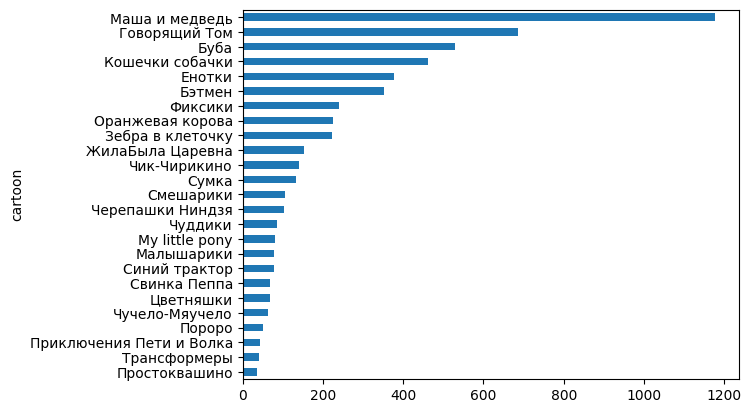

In [24]:
# взглянем на топ25 
data.query('cartoon != "none"')['cartoon'].value_counts()[:25].sort_values(ascending=True).plot(kind='barh');

In [25]:
len(data.query('cartoon == "none"'))

77576

Определим язык каналов и подписей

In [26]:
lang_list = []
for i, el in data.items():
    if i == 'reel_name':
        for num in range(0, len(data)):
            try :
                lang_list.append(detect(el[num]))
            except:
                lang_list.append('Not detected')
    else:
        pass

In [27]:
data['language'] = lang_list
data['language'].unique()

array(['ru', 'en', 'bg', 'ca', 'pl', 'no', 'uk', 'ja', 'mk', 'fr', 'et',
       'pt', 'ro', 'ar', 'sl', 'de', 'lt', 'cy', 'so', 'es', 'tr', 'da',
       'tl', 'sq', 'it', 'nl', 'id', 'sv', 'sw', 'el', 'af', 'hi', 'vi',
       'sk', 'ko', 'hr', 'Not detected', 'hu', 'fi', 'cs', 'zh-cn', 'fa'],
      dtype=object)

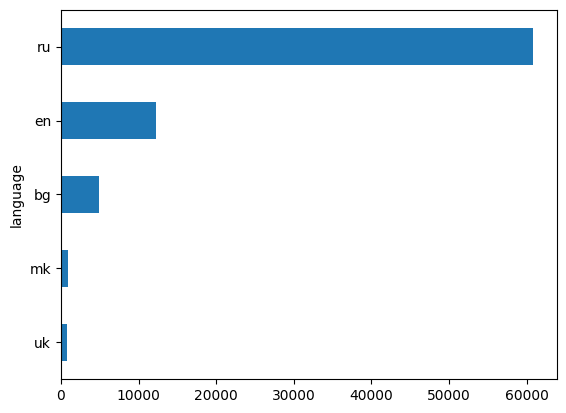

In [28]:
data['language'].value_counts()[:5].sort_values(ascending=True).plot(kind='barh');

In [29]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
# создадим множество со стоп словами для русского и английского языка
stop_words = set(nltk_stopwords.words('english')).union(set(nltk_stopwords.words('russian'))) # добавить stopwords для других яызков
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ZeleninAD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ZeleninAD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ZeleninAD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [31]:
data['yt_channel_name'].unique()

array(['Miss Katy', 'Boys and Toys', 'Nickelodeon_Cyrillic', 'Трум Трум',
       'Kedoo Toons TV Funny Animations', 'Лекс и Плу', 'Viki Show',
       'Теремок ТВ', 'Короткая анимация', 'Диана и Рома на русском',
       'КАЛЯКА МАЛЯКА', 'Vania Mania Kids', 'Yoko (Йоко)', 'Get Movies',
       'Masha and The Bear', 'Super Senya RU', 'Бэтмен', 'ДиДи ТВ',
       'Ya Alisa', 'Teremok Baby', 'Family Box', 'Теремок Kids', 'Рики',
       'D Billions На Русском', 'Like Nastya', 'Данкар',
       'HomeAnimations Мультики про тан', 'Доброе утро с Микки',
       'Мультики студии Союзмультфильм', 'КОШЕЧКИ СОБАЧКИ',
       'Guka Family Show', 'Бурёнка Даша', 'WB Kids International',
       'Nikol CrazyFamily', 'Теремок Песенки для детей', 'Dima Kids TV',
       'Теремок School', 'DadaZnay', 'SlivkiShow', 'Манкиту Сhannel',
       'Bush Baby World Пушастики', 'Funny Family Games tv',
       'Три Богатыря', 'LEV family SHOW RUS', 'SuperSofi', 'Mult Box TV',
       'Watch Me', 'Riki STUDY', 'BabyBus Песе

In [32]:
# data_ru = data.query('lang_list == "ru"')
# data_ru['cartoon'].value_counts()

In [33]:
data['clear_text'] = data['clear_text'].apply(lemmatize)
data[['text','clear_text']][:3]

,text,clear_text
0,[100 подарков и только один можно оставить себе],100 подарков оставить
1,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,забагали лизу реальной жизни артур настя follo...
2,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,грозная семейка лучшие сестринские моменты хло...


In [34]:
rubbish_words = ['мультик', 'мультики', 'мультфильм', 'мультфильмы',
                'фильм', 'фильмы', 'мульт',
                'детский', 'детские', 'детей',
                'сезон', 'серия', 'серий', 'серии', 'сер',
                'канал', 'канале',
                'cartoon', 'cart', 'kid']
cleaned_data = remove_words(data, 'clear_text', rubbish_words)
# cleaned_data['len_clear_name'] = cleaned_data['clear_name'].apply(lambda x: str(len(x)))

In [35]:
cleaned_data['clear_text'][4431]

'ксюша испортила свидание страшной учительнице 3d привет сосед страшная училка реальной жизни смотри watch  4  1 новое  страшную учительницу 3d устроила свидание моем доме привет соседом должна испортить свидание мои музыкальные клипы'

In [36]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83411 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          83411 non-null  float64
 7   is_shorts        83411 non-null  float64
 8   broadcast        83411 non-null  object 
 9   yt_channel_id    83411 non-null  object 
 10  yt_channel_name  83411 non-null  object 
 11  yt_ch_url        83411 non-null  object 
 12  yt_channel_type  83411 non-null  object 
 13  flag_closed      83411 non-null  float64
 14  international    83411 non-null  float64
 15  language         83411 non-null  object 
 16  clear_text       83411 non-null  object 
dtypes: float64(4

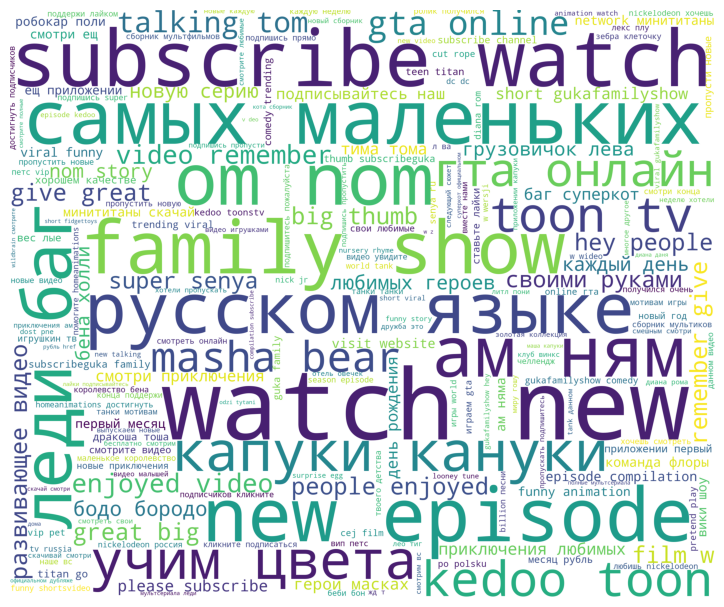

In [37]:
corpus = get_corpus(cleaned_data['clear_text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1);
plt.imshow(procWordCloud);
plt.axis('off');
plt.subplot(1, 2, 1);

### Работа с test файлом

In [38]:
test.sample(3)

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
36161,2024-08-24,"Гигиена Нет, не слышали Shorts машаимедведь П...",1GvR2pkKr_Y,https://www.youtube.com/watch?v=1GvR2pkKr_Y,"[Гигиена Нет, не слышали Shorts машаимедведь ...",22.0,1.0,none,UCYdtrIg2mfi8KkfNQUmQZoQ,TaDaBoom песенки для детей,https://youtube.com/channel/UCYdtrIg2mfi8KkfNQ...,Детские,0.0,0.0,NaN
44353,2022-09-05,Киси Миси в гостях у Басика Видео для детей п...,q8AhvupL2Rg,https://www.youtube.com/watch?v=q8AhvupL2Rg,[Киси Миси в гостях у Басика Видео для детей ...,314.0,0.0,none,UCFZLnAWs7zzAlsRwHXkiWwA,Первый Детский,https://youtube.com/channel/UCFZLnAWs7zzAlsRwH...,Детские,0.0,0.0,NaN
44204,2021-09-14,Матрос Петр Кошка дошкольные видео Kids Tv R...,DF7dpHPQxC8,https://www.youtube.com/watch?v=DF7dpHPQxC8,[Матрос Петр Кошка дошкольные видео Kids Tv ...,731.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN


In [39]:
test.loc[test['yt_reel_id'] == 'TbqhXXrqVMI', 'reel_name'] = 'emoji'
test.loc[test['yt_reel_id'] == 'u9NcRq-Ua6Y', 'reel_name'] = 'emoji'
test.loc[test['yt_reel_id'] == 'FUKpsV638os', 'reel_name'] = 'emoji'

In [41]:
test['yt_channel_id'].fillna('privat_or_delete_channel', inplace=True)

In [42]:
# обработаем как и train
test['clear_text'] = test['text'].apply(clear_text)
test['clear_text'] = test['clear_text'].apply(lemmatize)

In [43]:
cleaned_test = remove_words(test, 'clear_text', rubbish_words)
#cleaned_test['len_clear_name'] = cleaned_test['clear_name'].apply(lambda x: str(len(x)))

In [44]:
cleaned_test['feature_tfidf'] = cleaned_test['clear_text']+' '+ cleaned_test['yt_channel_id']#+' '+cleaned_test['len_clear_name']

### Моделирование 

In [45]:
# # уберем строку с записью "Губка Боб" в целевом признаке, т.к. у нас только одно наблюдение
# cleaned_data = cleaned_data_ru.query('cartoon != "Губка Боб"')

In [46]:
cleaned_data['feature_tfidf'] = cleaned_data['clear_text']+' '+ cleaned_data['yt_channel_id']#+' '+cleaned_data['len_clear_name']
#cleaned_data['feature_tfidf'][83403]

In [47]:
cleaned_data['cartoon'].value_counts()

cartoon
none                          77576
Маша и медведь                 1177
Говорящий Том                   687
Буба                            529
Кошечки собачки                 463
Енотки                          377
Бэтмен                          353
Фиксики                         239
Оранжевая корова                224
Зебра в клеточку                223
ЖилаБыла Царевна                154
Чик-Чирикино                    140
Сумка                           133
Смешарики                       105
Черепашки Ниндзя                104
Чуддики                          86
My little pony                   81
Малышарики                       77
Синий трактор                    77
Свинка Пеппа                     69
Цветняшки                        68
Чучело-Мяучело                   64
Пороро                           51
Приключения Пети и Волка         42
Трансформеры                     40
Простоквашино                    35
Щенячий патруль                  32
Царевны             

In [48]:
cleaned_data = cleaned_data[cleaned_data['feature_tfidf'].apply(lambda x: isinstance(x, str))]
# # таргет "вспыш" имеет одну запись, удалим его т.к. она не репрезентатива
cleaned_data = cleaned_data.query('cartoon!= "Вспыш"')

In [50]:
cleaned_data.reset_index(drop=True, inplace=True)
X = cleaned_data['feature_tfidf']  #[['is_shorts', 'seconds']]
y = cleaned_data['cartoon']

label_encoder = LabelEncoder()
y_coded = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y_coded, 
                                                  test_size=0.2,
                                                  random_state=RANDOM_STATE, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((66728,), (16682,), (66728,), (16682,))

In [51]:
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
def teach(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()), #max_features=1000
        ('model', model)])
    rs = GridSearchCV(pipeline, params, cv=3, n_jobs=-1, scoring='f1_macro', verbose=False, error_score='raise')
    rs.fit(X_train, y_train)
    print('Лучший результат:', rs.best_score_)
    print('Лучшие параметры:', rs.best_params_)
    return rs

In [52]:
#RandomForestClassifier
rndmf_model = teach(RandomForestClassifier(random_state=RANDOM_STATE),
                    {'model__criterion': ['gini','entropy'], 
                     'model__max_depth':range(5,50)})

Лучший результат: 0.27759132619041743
Лучшие параметры: {'model__criterion': 'entropy', 'model__max_depth': 48}


In [68]:
#SVC  0.7 rbf
svc_model = teach(SVC(random_state=RANDOM_STATE),
                  {'model__decision_function_shape': ['ovo']})#,
                   # 'model__kernel': ['rbf'], #, 'sigmoid'], #rbf
                   # 'model__gamma':['scale']}) #auto scale

Лучший результат: 0.6091161651577561
Лучшие параметры: {'model__decision_function_shape': 'ovo'}


In [54]:
#KNeighborsClassifier
knn_model = teach(KNeighborsClassifier(), 
                  {'model__n_neighbors':[3, 5]})

Лучший результат: 0.7227666209462731
Лучшие параметры: {'model__n_neighbors': 3}


In [55]:
#XGBClassifier
xgb_model = teach(XGBClassifier(random_state=RANDOM_STATE), 
                  {'model__objective':['multi:softprob'],
                   'model__eval_metric':['merror','mlogloss']})

Лучший результат: 0.6832021331643324
Лучшие параметры: {'model__eval_metric': 'merror', 'model__objective': 'multi:softprob'}


In [56]:
# #LGBMClassifier
# lgbm_model = teach(lgb.LGBMClassifier(random_state=RANDOM_STATE), {'model__boosting_type':['gbdt'],
#                                                                    'model__application':['multiclass'],
#                                                                    'model__learning_rate':[0.01]})

In [57]:
# #y_val = label_encoder.transform(y_val)
# res_lgbm = f1_score(y_val, lgbm_model.predict(X_val), average='macro')
# print(f"Результат LGBMClassifier f1_macro - {res_lgbm.round(2)}")

In [58]:
res_rf = f1_score(y_val, rndmf_model.predict(X_val), average='macro')
print(f"Результат RandomForestClassifier f1_macro - {res_rf.round(2)}")

Результат RandomForestClassifier f1_macro - 0.25


In [59]:
# res_svc = f1_score(y_val, svc_model.predict(X_val), average='macro')
# print(f"Результат SVC f1_macro - {res_svc.round(2)}")

In [60]:
res_knn = f1_score(y_val, knn_model.predict(X_val), average='macro')
print(f"Результат KNeighborsClassifier f1_macro - {res_knn.round(2)}")

Результат KNeighborsClassifier f1_macro - 0.77


In [61]:
res_xgb = f1_score(y_val, xgb_model.predict(X_val), average='macro')
print(f"Результат XGBClassifier f1_macro - {res_xgb.round(2)}")

Результат XGBClassifier f1_macro - 0.76


Лучшие результаты показала модель Knn - 0.77 на валидационной выборке!

In [63]:
predictions = knn_model.predict(cleaned_test['feature_tfidf'])

In [64]:
preds_decoded = label_encoder.inverse_transform(predictions)

In [65]:
results = pd.DataFrame({
    'yt_reel_id': cleaned_test['yt_reel_id'], 
    'cartoon': preds_decoded})

In [66]:
results.to_csv("results_22_10.csv", index=False)

In [67]:
results.head()

,yt_reel_id,cartoon
0,RBw4j0aMWyM,none
1,5wTfpmlZe5k,none
2,Fd9YA-oDjSo,none
3,NXCHY_J-5v0,none
4,XM-GRekoYzs,none
